In [1]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated
from langchain_core.messages import BaseMessage,HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [6]:
# Tools

search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num:float,second_num:float,operation: str)->dict:
    """
    perform a basic arithmetic operation on two numbers.
    Supported operations: add, subtract, mul, and div
    """

    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed."}
            result = first_num / second_num
        else:
            return {"error": "Unsupported operation. Please use add, sub, mul, or div."}
        
        return {"result": result}
    except Exception as e:
        return {"error": str(e)}
    

@tool
def get_stock_price(symbol: str)->dict:
    """
    Fetch latest stock price for a given symbol (e.g 'AAPL','TSLA')
    using Alpha vantage with API key in the URL
    """

    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=43M0JWCXQK4D3L4N"
    r = requests.get(url)

    return r.json()


In [7]:
# Make tool list
tools = [get_stock_price,calculator,search_tool]

llm_with_tools = llm.bind_tools(tools)

In [8]:
# state graph
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [9]:
# graph node
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call"""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {'messages':[response]}

tool_node = ToolNode(tools)

In [18]:
# graph Structure
graph = StateGraph(ChatState)
graph.add_node('chat_node',chat_node)
graph.add_node('tools',tool_node)

In [19]:
graph.add_edge(START,'chat_node')

graph.add_conditional_edges("chat_node",tools_condition)

graph.add_edge('tools','chat_node')

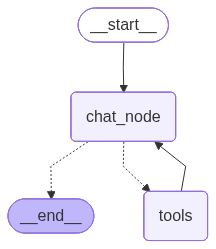

In [20]:
chatbot = graph.compile()
chatbot

In [13]:
# regular chat
out = chatbot.invoke({'messages':[HumanMessage(content="Hii")]})

print(out["messages"][-1].content)
                      

Hello! How can I help you today?


In [21]:
# regular chat
out = chatbot.invoke({'messages':[HumanMessage(content="what is 2*3?")]})

print(out["messages"][-1].content)

2*3 is 6.


In [ ]:
# regular chat
out = chatbot.invoke({'messages':[HumanMessage(content="What is the stock price of Apple?")]})

print(out["messages"][-1].content)

{"Global Quote": {"01. symbol": "AAPL", "02. open": "265.9500", "03. high": "273.3300", "04. low": "265.6700", "05. price": "271.4900", "06. volume": "59030832", "07. latest trading day": "2025-11-21", "08. previous close": "266.2500", "09. change": "5.2400", "10. change percent": "1.9681%"}}


In [22]:
# regular chat
out = chatbot.invoke({'messages':[HumanMessage(content="What is the stock price of Apple/ How much it when you multiple with 50?")]})

print(out["messages"][-1].content)

The current stock price of Apple is $271.49. When you multiply that by 50, the result is $13574.5.
